# Proyecto final: Modelización

## Objetivo

Debemos construir un modelo de clasificación que prediga la probabilidad de que un paciente haya sufrido algún tipo de enfermedad cardíaca. Se ha de tener en cuenta que decirle a un asegurado que tiene una enfermedad cardíaca cuando realmente no la ha tenido supone un riesgo de pérdida de clientes y, en consecuencia, de ingresos mucho mayor que el hecho de no asignarle una enfermedad cardíaca a alguien que si la ha tenido. La aseguradora considera crucial que esta característica se vea reflejada en el modelo construido.

## 1. Librerías y datos

### 1.1 Instalación de librerías e importación

In [10]:
pip install xgboost

     |████████████████████████████████| 1.8 MB 2.1 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [13]:
pip install bayesian-optimization

Note: you may need to restart the kernel to use updated packages.


In [21]:
pip install imbalanced-learn


Note: you may need to restart the kernel to use updated packages.


In [23]:
pip install threadpoolctl==3.1.0

  Attempting uninstall: threadpoolctl
    Found existing installation: threadpoolctl 2.2.0
    Uninstalling threadpoolctl-2.2.0:
      Successfully uninstalled threadpoolctl-2.2.0
Note: you may need to restart the kernel to use updated packages.


In [131]:
# Librerías

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots

from itertools import compress

import xgboost as xgb
from xgboost import cv
from bayes_opt import BayesianOptimization
import pickle as pk

### 1.2 Lectura de los datos

In [26]:
df = pd.read_csv("../Datos/heart_2020_cleaned.csv")

In [27]:
df.head(10)

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
0,No,16.60,Yes,No,No,3.0,30.0,No,Female,55-59,White,Yes,Yes,Very good,5.0,Yes,No,Yes
1,No,20.34,No,No,Yes,0.0,0.0,No,Female,80 or older,White,No,Yes,Very good,7.0,No,No,No
2,No,26.58,Yes,No,No,20.0,30.0,No,Male,65-69,White,Yes,Yes,Fair,8.0,Yes,No,No
3,No,24.21,No,No,No,0.0,0.0,No,Female,75-79,White,No,No,Good,6.0,No,No,Yes
4,No,23.71,No,No,No,28.0,0.0,Yes,Female,40-44,White,No,Yes,Very good,8.0,No,No,No
5,Yes,28.87,Yes,No,No,6.0,0.0,Yes,Female,75-79,Black,No,No,Fair,12.0,No,No,No
6,No,21.63,No,No,No,15.0,0.0,No,Female,70-74,White,No,Yes,Fair,4.0,Yes,No,Yes
7,No,31.64,Yes,No,No,5.0,0.0,Yes,Female,80 or older,White,Yes,No,Good,9.0,Yes,No,No
8,No,26.45,No,No,No,0.0,0.0,No,Female,80 or older,White,"No, borderline diabetes",No,Fair,5.0,No,Yes,No
9,No,40.69,No,No,No,0.0,0.0,Yes,Male,65-69,White,No,Yes,Good,10.0,No,No,No


## 2. Codificación de variables categóricas

In [28]:
# Antes de nada, un vistazo general a las categorías de cada una de las vars. no numéricas

categorical = df.select_dtypes(include=object)
categorical.head(5)

,HeartDisease,Smoking,AlcoholDrinking,Stroke,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,Asthma,KidneyDisease,SkinCancer
0,No,Yes,No,No,No,Female,55-59,White,Yes,Yes,Very good,Yes,No,Yes
1,No,No,No,Yes,No,Female,80 or older,White,No,Yes,Very good,No,No,No
2,No,Yes,No,No,No,Male,65-69,White,Yes,Yes,Fair,Yes,No,No
3,No,No,No,No,No,Female,75-79,White,No,No,Good,No,No,Yes
4,No,No,No,No,Yes,Female,40-44,White,No,Yes,Very good,No,No,No


In [29]:
for col in categorical.columns:
    print("\n" + '\033[1m'+ str(col) + '\033[0m')
    print(pd.value_counts(categorical[col]))


HeartDisease
No     292422
Yes     27373
Name: HeartDisease, dtype: int64

Smoking
No     187887
Yes    131908
Name: Smoking, dtype: int64

AlcoholDrinking
No     298018
Yes     21777
Name: AlcoholDrinking, dtype: int64

Stroke
No     307726
Yes     12069
Name: Stroke, dtype: int64

DiffWalking
No     275385
Yes     44410
Name: DiffWalking, dtype: int64

Sex
Female    167805
Male      151990
Name: Sex, dtype: int64

AgeCategory
65-69          34151
60-64          33686
70-74          31065
55-59          29757
50-54          25382
80 or older    24153
45-49          21791
75-79          21482
18-24          21064
40-44          21006
35-39          20550
30-34          18753
25-29          16955
Name: AgeCategory, dtype: int64

Race
White                             245212
Hispanic                           27446
Black                              22939
Other                              10928
Asian                               8068
American Indian/Alaskan Native      5202
Name: Race

### 2.1 *Label encoding* para variables ordinales

Teniendo en cuenta lo que hemos visto anteriormente, podemos distinguir las siguientes dos variables **ordinales**: **GenHealth** y **AgeCategory**. No consideraremos *Diabetic* como ordinal porque no es evidente como habría de ordenarse la categoría "*Yes (during pregnancy)*" dentro de una escala unidimensional de intensidad de diabetes.

In [30]:
# Import label encoder
from sklearn.preprocessing import LabelEncoder
  
# Applying  encoding to ordinal categorical variables
label_encoder = LabelEncoder()
df_encoded = df.copy()
df_encoded['GenHealth']= label_encoder.fit_transform(df['GenHealth'])
df_encoded['AgeCategory']= label_encoder.fit_transform(df['AgeCategory'])

df_encoded[['GenHealth', 'AgeCategory']].head(10)

,GenHealth,AgeCategory
0,4,7
1,4,12
2,1,9
3,2,11
4,4,4
5,1,11
6,1,10
7,2,12
8,1,12
9,2,9


### 2.2 *One Hot encoding* para variables no ordinales

In [31]:
df_encoded = pd.get_dummies(df_encoded, drop_first=True)
df_encoded.head(5)

,BMI,PhysicalHealth,MentalHealth,AgeCategory,GenHealth,SleepTime,HeartDisease_Yes,Smoking_Yes,AlcoholDrinking_Yes,Stroke_Yes,...,Race_Hispanic,Race_Other,Race_White,"Diabetic_No, borderline diabetes",Diabetic_Yes,Diabetic_Yes (during pregnancy),PhysicalActivity_Yes,Asthma_Yes,KidneyDisease_Yes,SkinCancer_Yes
0,16.60,3.0,30.0,7,4,5.0,0,1,0,0,...,0,0,1,0,1,0,1,1,0,1
1,20.34,0.0,0.0,12,4,7.0,0,0,0,1,...,0,0,1,0,0,0,1,0,0,0
2,26.58,20.0,30.0,9,1,8.0,0,1,0,0,...,0,0,1,0,1,0,1,1,0,0
3,24.21,0.0,0.0,11,2,6.0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
4,23.71,28.0,0.0,4,4,8.0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0


## 3. Train-test separation

Antes de aplicar técnicas de selección de variables y cualquier otro pre-procesamiento restante, partiremos los datos en los subconjuntos de train y test. Los criterios y algoritmos de selección de variables se aplicarán sobre train para identificar los atributos a eliminar, y posteriormente se eliminarán esos mismos atributos del subconjunto de test.

In [32]:
# Train-test separation
X = df_encoded.drop(['HeartDisease_Yes'], axis=1)
y = df_encoded[['HeartDisease_Yes']]

X_train, X_test, y_train, y_test = train_test_split(X, y ,test_size = 0.3, random_state = 123)

print("\n" + '\033[1m'+ 'Distribución del target en train' + '\033[0m')
print(pd.value_counts(y_train['HeartDisease_Yes']))

print("\n" + '\033[1m'+ 'Distribución del target en test' + '\033[0m')
print(pd.value_counts(y_test['HeartDisease_Yes']))


Distribución del target en train
0    204876
1     18980
Name: HeartDisease_Yes, dtype: int64

Distribución del target en test
0    87546
1     8393
Name: HeartDisease_Yes, dtype: int64


Se mantienen porcentajes similares de target=1 en train (9.26%) y test (9.58%), por lo que no vemos necesario aplicar sampling estratificado

In [33]:
# La estandarización de variables previa al entrenamiento nos interesa para evaluar 
# posteriormente la importancia de cada variable

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

## 4. Selección de variables

Existen múltiples técnicas y criterios que pueden aplicarse. Nosotros nos hemos decantado por los que se muestran a continuación.

### 4.1 Eliminación de variables altamente correladas

In [34]:
df.corr()

,BMI,PhysicalHealth,MentalHealth,SleepTime
BMI,1.000000,0.109788,0.064131,-0.051822
PhysicalHealth,0.109788,1.000000,0.287987,-0.061387
MentalHealth,0.064131,0.287987,1.000000,-0.119717
SleepTime,-0.051822,-0.061387,-0.119717,1.000000


Ningun atributo presenta un coeficiente de correlación de Pearson alto; de hecho la correlación lineal entre las variables numéricas de nuestro conjunto de datos es notablemente bajo. No hay por tanto información redundante que entorpezca el entrenamiento provocando el sobreajuste del modelo al ruido.

### 4.2 Recursive Feature Elimination

In [60]:
classifier = xgb.XGBClassifier()

# perform Recursive Feature Elimination (RFE)
from sklearn.feature_selection import RFE
# here we want only one final feature, we do this to produce a ranking
n_features_to_select = 1
rfe = RFE(classifier, n_features_to_select=n_features_to_select)
rfe.fit(X_train_scaled, y_train)

# Print out the features in order of ranking
from operator import itemgetter
features = X_train_scaled.columns.to_list()
for x, y in (sorted(zip(rfe.ranking_ , features), key=itemgetter(0))):
    print(x, y)

1 AgeCategory
2 Stroke_Yes
3 GenHealth
4 DiffWalking_Yes
5 Diabetic_Yes
6 Sex_Male
7 KidneyDisease_Yes
8 Smoking_Yes
9 PhysicalHealth
10 Race_White
11 Asthma_Yes
12 AlcoholDrinking_Yes
13 Race_Black
14 Race_Hispanic
15 SkinCancer_Yes
16 Race_Other
17 SleepTime
18 Race_Asian
19 Diabetic_Yes (during pregnancy)
20 BMI
21 MentalHealth
22 Diabetic_No, borderline diabetes
23 PhysicalActivity_Yes


Las visualizaciones del EDA corroboran que no hay distinciones notables entre los valores medios de BMI y MentalHealth entre enfermos y no enfermos, por lo que las eliminaremos. Las dummies categoricas que estén por debajo también las eliminaremos. Nos queda un total de 19 variables.

In [35]:
X_train_scaled = X_train_scaled.drop(['BMI','MentalHealth', 'Diabetic_No, borderline diabetes', 'PhysicalActivity_Yes'], axis=1)
X_test_scaled = X_test_scaled.drop(['BMI','MentalHealth', 'Diabetic_No, borderline diabetes', 'PhysicalActivity_Yes'], axis=1)

## 5. Tratamiento previo a la modelización

### 5.1 Enriquecimiento del dataset: Clustering k-means

In [36]:
# Aplicamos clustering

intertia = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k, random_state = 123)
    kmeanModel.fit(X_train_scaled)
    intertia.append(kmeanModel.inertia_)

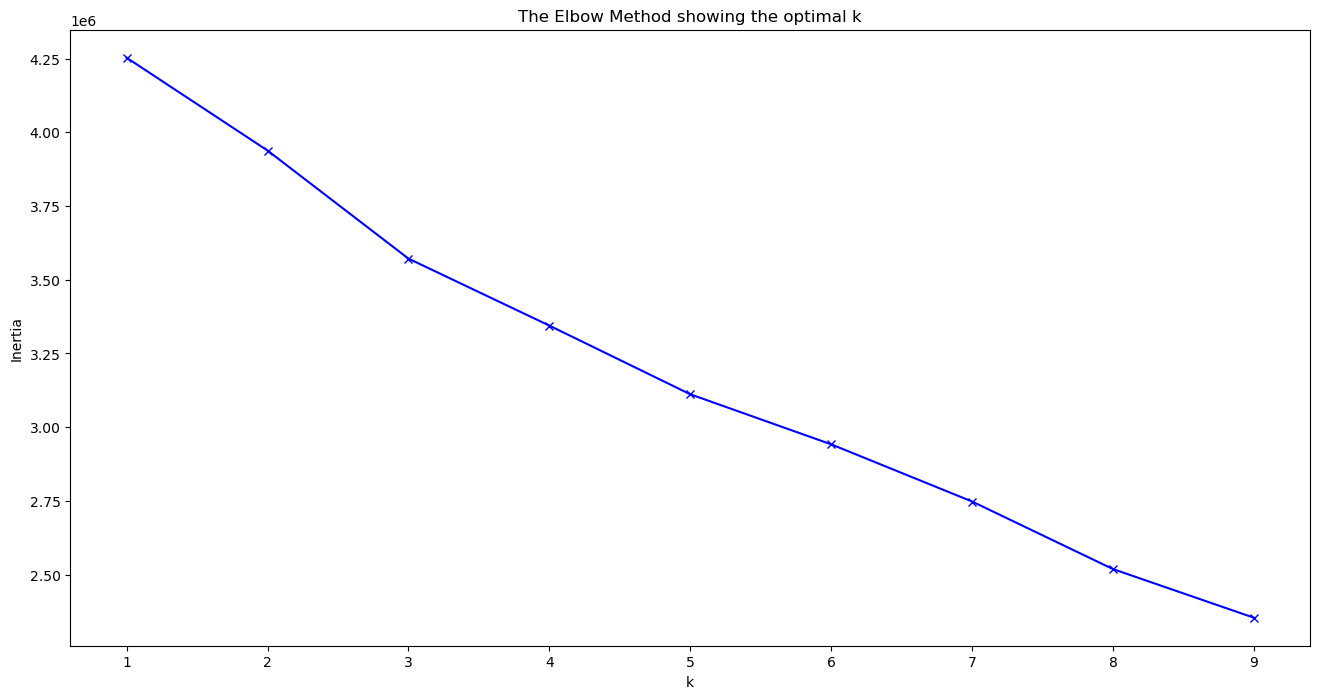

In [37]:
plt.figure(figsize=(16,8))
plt.plot(K, intertia, 'bx-')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [38]:
cluster = KMeans(n_clusters = 4, random_state = 123)
cluster.fit(X_train_scaled)

prediction_train = cluster.predict(X_train_scaled)
X_train_prepared = X_train_scaled.copy()
X_train_prepared['cluster'] = prediction_train

prediction_test = cluster.predict(X_test_scaled)
X_test_prepared = X_test_scaled.copy()
X_test_prepared['cluster'] = prediction_test

In [15]:
classifier = xgb.XGBClassifier()

# perform Recursive Feature Elimination (RFE)
from sklearn.feature_selection import RFE
# here we want only one final feature, we do this to produce a ranking
n_features_to_select = 1
rfe = RFE(classifier, n_features_to_select=n_features_to_select)
rfe.fit(X_train_prepared, y_train)

# Print out the features in order of ranking
from operator import itemgetter
features = X_train_prepared.columns.to_list()
for x, y in (sorted(zip(rfe.ranking_ , features), key=itemgetter(0))):
    print(x, y)

1 cluster
2 AgeCategory
3 GenHealth
4 Stroke_Yes
5 Sex_Male
6 Diabetic_Yes
7 KidneyDisease_Yes
8 Smoking_Yes
9 Race_White
10 PhysicalHealth
11 Asthma_Yes
12 DiffWalking_Yes
13 AlcoholDrinking_Yes
14 Race_Black
15 SkinCancer_Yes
16 Race_Other
17 Race_Hispanic
18 SleepTime
19 Race_Asian
20 Diabetic_Yes (during pregnancy)


La varaible 'cluster' parece claramente relevante, así que la mantendremos. A cambio, vamos a eliminar Diabetic_Yes (during pregnancy). Tiene sentido que padecer diabetes transitoriamente fruto de un emparazo no afecte significativamente el riesgo de padecer enfermedades cardiacas.

In [39]:
X_train_scaled = X_train_scaled.drop(['Diabetic_Yes (during pregnancy)'], axis=1)
X_test_scaled = X_test_scaled.drop(['Diabetic_Yes (during pregnancy)'], axis=1)

### 5.2 Oversampling de la clase minoritaria

In [43]:
# Oversampling
from collections import Counter
from imblearn.over_sampling import SMOTE, SVMSMOTE, BorderlineSMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

over = BorderlineSMOTE(sampling_strategy=0.4)
under = RandomUnderSampler(sampling_strategy=0.6)

steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)

# transform the dataset
X_train_balanced, y_train_balanced = pipeline.fit_resample(X_train_scaled, y_train)

print("\n" + '\033[1m'+ 'Distribución del target en train antes de balancear' + '\033[0m')
print(pd.value_counts(y_train['HeartDisease_Yes']))

print("\n" + '\033[1m'+ 'Distribución del target en train después de balancear' + '\033[0m')
print(pd.value_counts(y_train_balanced['HeartDisease_Yes']))


Distribución del target en train antes de balancear
0    204876
1     18980
Name: HeartDisease_Yes, dtype: int64

Distribución del target en train después de balancear
0    136583
1     81950
Name: HeartDisease_Yes, dtype: int64


## 6. Modelización

In [41]:
# Conjunto de validación para búsqueda Bayesiana
X_test, X_val, y_test, y_val = train_test_split(X_test_scaled, #_balanced
                                                y_test, #_balanced
                                                test_size = 0.5, 
                                                random_state = 123)

In [44]:
# Busqueda Bayesiana de hiperparámetros PROBAR con LightGBM. Optuna en lugar de bayes?

# Defining the search space
space = {"eta": (0, 1),
         "gamma":(0, 10), 
         "max_depth":(2, 12),
         "min_child_weight": (0, 5),
         "learning_rate": (0.001, 0.1)}

# Defining the objective function
def objective(eta, gamma, max_depth, min_child_weight, learning_rate):
    
    """
    Objective function to minimize for the Bayesian optimizer
        
    Parameters
    ==========
    eta, gamma, max_depth, min_child_weight
        
    Return
    ======
        
    loss : Cost value to minimize (in this case, binary_crossentropy)
    
    """
        
    max_depth = round(max_depth)
    min_child_weight = round(min_child_weight)
    
    
    # Creating the model
    model = xgb.XGBClassifier(random_state=1, 
                              learning_rate=learning_rate, 
                              n_estimators=500,
                              eta=eta,
                              gamma=gamma,
                              max_depth=max_depth,
                              min_child_weight=min_child_weight)
    # Fit the model
    model.fit(X_train_balanced, y_train_balanced)  # X_train_scaled, y_train
        
    # Evaluating the model
    y_val_pred = model.predict(X_val)  # Aplicar mejor cross validation?

    #accuracy = accuracy_score(y_test_val, y_test_val_pred)
    #f1 = f1_score(y_test_val, y_test_val_pred) COMO HEMOS BALANCEADO, PODEMOS CENTRARNOS EN LA PRECISION
    
    precision = precision_score(y_val, y_val_pred)
    
        
    return precision

# Create the optimizer
optimizer = BayesianOptimization(
    f=objective,
    pbounds=space,
    random_state=1,
)
    
# Running the optimizer...
optimizer.maximize(
    init_points=2,
    n_iter=45,
)
    
# Optimal parameter values
params = optimizer.max['params']

|   iter    |  target   |    eta    |   gamma   | learni... | max_depth | min_ch... |
-------------------------------------------------------------------------------------
|  1        |  0.2479   |  0.417    |  7.203    |  0.001011 |  5.023    |  0.7338   |
|  2        |  0.3316   |  0.09234  |  1.863    |  0.03521  |  5.968    |  2.694    |
|  3        |  0.3314   |  0.304    |  1.963    |  0.07443  |  6.257    |  2.726    |
|  4        |  0.2883   |  0.0      |  0.0      |  0.001    |  10.74    |  5.0      |
|  5        |  0.3335   |  1.0      |  0.0      |  0.1      |  3.9      |  5.0      |
|  6        |  0.3485   |  1.0      |  0.0      |  0.1      |  2.0      |  0.2316   |
|  7        |  0.3289   |  1.0      |  0.0      |  0.1      |  6.127    |  0.0      |
|  8        |  0.324    |  1.0      |  10.0     |  0.1      |  12.0     |  5.0      |
|  9        |  0.3473   |  1.0      |  3.073    |  0.1      |  2.0      |  5.0      |
|  10       |  0.3485   |  0.0      |  0.0      |  0.1

In [45]:
# Creating the model
xgb_model = xgb.XGBClassifier(use_label_encoder=False, 
                              random_state=1, 
                              learning_rate=params['learning_rate'], 
                              n_estimators=600,
                              eta=params['eta'],
                              gamma=params['gamma'],
                              max_depth=round(params['max_depth']),
                              min_child_weight=round(params['min_child_weight']))

# Fit the model
xgb_model.fit(X_train_balanced, y_train_balanced) # X_train_scaled, y_train
        
# Evaluating the model
y_test_pred = xgb_model.predict(X_test)

accuracy = accuracy_score(y_test, y_test_pred)

print(accuracy)

0.8815485000729638


In [46]:
conf_matrix = confusion_matrix(y_test, y_test_pred)
conf_matrix

array([[40552,  3229],
       [ 2453,  1735]])

In [60]:
# create annotations for each cell in the confusion matrix
annotations = []
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        annotations.append(dict(
            x=j,
            y=i,
            text=str(conf_matrix[i, j]),
            showarrow=False,
            font=dict(color='white')
        ))

# plot the confusion matrix using plotly
fig = go.Figure(data=go.Heatmap(
    z=conf_matrix,
    x=['Predicted 0', 'Predicted 1'],
    y=['Actual 0', 'Actual 1'],
    colorscale='Viridis',
    zmin=0,
    zmax=conf_matrix.max()
))
fig.update_layout(annotations=annotations)
fig.show()


### Probando con otros modelos

In [64]:
# Busqueda Bayesiana de hiperparámetros

# Importing the necessary libraries
from sklearn.ensemble import RandomForestClassifier

# Defining the search space
space_rf = {"n_estimators": (10, 100),
         "max_depth": (2, 12),
         "min_samples_split": (2, 10),
         "min_samples_leaf": (1, 5)}

# Defining the objective function
def objective_rf(n_estimators, max_depth, min_samples_split, min_samples_leaf):
    
    """
    Objective function to minimize for the Bayesian optimizer
        
    Parameters
    ==========
    n_estimators, max_depth, min_samples_split, min_samples_leaf
        
    Return
    ======
        
    loss : Cost value to minimize (in this case, binary_crossentropy)
    
    """

    n_estimators = round(n_estimators)
    max_depth = round(max_depth)
    min_samples_split = round(min_samples_split)
    min_samples_leaf = round(min_samples_leaf)
    
    # Creating the model
    model = RandomForestClassifier(random_state=1,
                                   n_estimators=n_estimators,
                                   max_depth=max_depth,
                                   min_samples_split=min_samples_split,
                                   min_samples_leaf=min_samples_leaf)
    # Fit the model
    model.fit(X_train_balanced, y_train_balanced)  # X_train_scaled, y_train
        
    # Evaluating the model
    y_val_pred = model.predict(X_val)  # Aplicar mejor cross validation?

    #accuracy = accuracy_score(y_test_val, y_test_val_pred)
    #f1 = f1_score(y_test_val, y_test_val_pred) COMO HEMOS BALANCEADO, PODEMOS CENTRARNOS EN LA PRECISION
    
    precision = precision_score(y_val, y_val_pred)
    
        
    return precision

# Create the optimizer
optimizer_rf = BayesianOptimization(
    f=objective_rf,
    pbounds=space_rf,
    random_state=1,
)
    
# Running the optimizer...
optimizer_rf.maximize(
    init_points=2,
    n_iter=45,
)
    
# Optimal parameter values
params = optimizer_rf.max['params']


|   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------


/var/folders/n5/q17mp4yj0fg4l0nnzg4h71_c0000gn/T/ipykernel_43888/699742015.py:41: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



|  1        |  0.275    |  6.17     |  3.881    |  2.001    |  37.21    |


/var/folders/n5/q17mp4yj0fg4l0nnzg4h71_c0000gn/T/ipykernel_43888/699742015.py:41: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



|  2        |  0.2909   |  3.468    |  1.369    |  3.49     |  41.1     |


/var/folders/n5/q17mp4yj0fg4l0nnzg4h71_c0000gn/T/ipykernel_43888/699742015.py:41: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



|  3        |  0.2909   |  2.96     |  1.905    |  3.033    |  40.94    |


/var/folders/n5/q17mp4yj0fg4l0nnzg4h71_c0000gn/T/ipykernel_43888/699742015.py:41: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



|  4        |  0.2867   |  2.038    |  1.005    |  2.091    |  45.23    |


/var/folders/n5/q17mp4yj0fg4l0nnzg4h71_c0000gn/T/ipykernel_43888/699742015.py:41: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



|  5        |  0.2914   |  2.0      |  2.766    |  7.09     |  42.18    |


/var/folders/n5/q17mp4yj0fg4l0nnzg4h71_c0000gn/T/ipykernel_43888/699742015.py:41: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



|  6        |  0.2721   |  5.608    |  1.0      |  10.0     |  44.75    |


/var/folders/n5/q17mp4yj0fg4l0nnzg4h71_c0000gn/T/ipykernel_43888/699742015.py:41: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



|  7        |  0.2926   |  2.187    |  1.699    |  6.862    |  38.77    |


/var/folders/n5/q17mp4yj0fg4l0nnzg4h71_c0000gn/T/ipykernel_43888/699742015.py:41: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



|  8        |  0.2923   |  2.0      |  5.0      |  10.0     |  36.31    |


/var/folders/n5/q17mp4yj0fg4l0nnzg4h71_c0000gn/T/ipykernel_43888/699742015.py:41: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



|  9        |  0.2922   |  2.232    |  1.809    |  9.506    |  32.34    |


/var/folders/n5/q17mp4yj0fg4l0nnzg4h71_c0000gn/T/ipykernel_43888/699742015.py:41: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



|  10       |  0.2907   |  2.0      |  5.0      |  10.0     |  26.94    |


/var/folders/n5/q17mp4yj0fg4l0nnzg4h71_c0000gn/T/ipykernel_43888/699742015.py:41: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



|  11       |  0.2766   |  7.516    |  1.0      |  10.0     |  27.64    |


/var/folders/n5/q17mp4yj0fg4l0nnzg4h71_c0000gn/T/ipykernel_43888/699742015.py:41: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



|  12       |  0.288    |  2.038    |  4.735    |  5.66     |  20.44    |


/var/folders/n5/q17mp4yj0fg4l0nnzg4h71_c0000gn/T/ipykernel_43888/699742015.py:41: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



|  13       |  0.2922   |  2.0      |  5.0      |  6.83     |  31.58    |


/var/folders/n5/q17mp4yj0fg4l0nnzg4h71_c0000gn/T/ipykernel_43888/699742015.py:41: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



|  14       |  0.2726   |  2.567    |  4.725    |  3.031    |  10.5     |


/var/folders/n5/q17mp4yj0fg4l0nnzg4h71_c0000gn/T/ipykernel_43888/699742015.py:41: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



|  15       |  0.2878   |  11.65    |  4.928    |  2.118    |  99.7     |


/var/folders/n5/q17mp4yj0fg4l0nnzg4h71_c0000gn/T/ipykernel_43888/699742015.py:41: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



|  16       |  0.2967   |  2.0      |  5.0      |  2.0      |  26.47    |


/var/folders/n5/q17mp4yj0fg4l0nnzg4h71_c0000gn/T/ipykernel_43888/699742015.py:41: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



|  17       |  0.2967   |  2.0      |  1.0      |  2.0      |  26.32    |


/var/folders/n5/q17mp4yj0fg4l0nnzg4h71_c0000gn/T/ipykernel_43888/699742015.py:41: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



|  18       |  0.2914   |  3.065    |  2.039    |  9.456    |  90.33    |


/var/folders/n5/q17mp4yj0fg4l0nnzg4h71_c0000gn/T/ipykernel_43888/699742015.py:41: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



|  19       |  0.2785   |  7.967    |  2.614    |  6.18     |  84.49    |


/var/folders/n5/q17mp4yj0fg4l0nnzg4h71_c0000gn/T/ipykernel_43888/699742015.py:41: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



|  20       |  0.2794   |  6.035    |  3.461    |  2.0      |  24.38    |


/var/folders/n5/q17mp4yj0fg4l0nnzg4h71_c0000gn/T/ipykernel_43888/699742015.py:41: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



|  21       |  0.2915   |  2.0      |  2.563    |  2.0      |  29.68    |


/var/folders/n5/q17mp4yj0fg4l0nnzg4h71_c0000gn/T/ipykernel_43888/699742015.py:41: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



|  22       |  0.2933   |  2.02     |  2.864    |  5.948    |  27.56    |


/var/folders/n5/q17mp4yj0fg4l0nnzg4h71_c0000gn/T/ipykernel_43888/699742015.py:41: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



|  23       |  0.2872   |  2.0      |  1.384    |  10.0     |  96.97    |


/var/folders/n5/q17mp4yj0fg4l0nnzg4h71_c0000gn/T/ipykernel_43888/699742015.py:41: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



|  24       |  0.2897   |  2.0      |  1.0      |  2.0      |  93.39    |


/var/folders/n5/q17mp4yj0fg4l0nnzg4h71_c0000gn/T/ipykernel_43888/699742015.py:41: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



|  25       |  0.2848   |  11.89    |  3.868    |  2.227    |  65.0     |


/var/folders/n5/q17mp4yj0fg4l0nnzg4h71_c0000gn/T/ipykernel_43888/699742015.py:41: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



|  26       |  0.2802   |  8.821    |  4.424    |  9.506    |  94.54    |


/var/folders/n5/q17mp4yj0fg4l0nnzg4h71_c0000gn/T/ipykernel_43888/699742015.py:41: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



|  27       |  0.2917   |  2.445    |  2.773    |  2.114    |  99.37    |


/var/folders/n5/q17mp4yj0fg4l0nnzg4h71_c0000gn/T/ipykernel_43888/699742015.py:41: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



|  28       |  0.2908   |  2.0      |  2.689    |  10.0     |  63.26    |


/var/folders/n5/q17mp4yj0fg4l0nnzg4h71_c0000gn/T/ipykernel_43888/699742015.py:41: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



|  29       |  0.2767   |  2.247    |  3.995    |  9.616    |  69.57    |


/var/folders/n5/q17mp4yj0fg4l0nnzg4h71_c0000gn/T/ipykernel_43888/699742015.py:41: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



|  30       |  0.2938   |  2.0      |  1.0      |  9.433    |  58.29    |


/var/folders/n5/q17mp4yj0fg4l0nnzg4h71_c0000gn/T/ipykernel_43888/699742015.py:41: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



|  31       |  0.2847   |  2.603    |  4.331    |  5.862    |  59.36    |


/var/folders/n5/q17mp4yj0fg4l0nnzg4h71_c0000gn/T/ipykernel_43888/699742015.py:41: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



|  32       |  0.2749   |  6.477    |  1.087    |  9.362    |  57.96    |


/var/folders/n5/q17mp4yj0fg4l0nnzg4h71_c0000gn/T/ipykernel_43888/699742015.py:41: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



|  33       |  0.2917   |  2.417    |  1.344    |  9.833    |  36.66    |


/var/folders/n5/q17mp4yj0fg4l0nnzg4h71_c0000gn/T/ipykernel_43888/699742015.py:41: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



|  34       |  0.2999   |  2.0      |  5.0      |  4.771    |  25.35    |


/var/folders/n5/q17mp4yj0fg4l0nnzg4h71_c0000gn/T/ipykernel_43888/699742015.py:41: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



|  35       |  0.3003   |  2.242    |  3.258    |  3.229    |  24.12    |


/var/folders/n5/q17mp4yj0fg4l0nnzg4h71_c0000gn/T/ipykernel_43888/699742015.py:41: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



|  36       |  0.3003   |  2.13     |  1.091    |  3.534    |  24.26    |


/var/folders/n5/q17mp4yj0fg4l0nnzg4h71_c0000gn/T/ipykernel_43888/699742015.py:41: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



|  37       |  0.3057   |  2.0      |  1.0      |  6.62     |  23.3     |


/var/folders/n5/q17mp4yj0fg4l0nnzg4h71_c0000gn/T/ipykernel_43888/699742015.py:41: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



|  38       |  0.2835   |  2.578    |  1.192    |  9.454    |  21.56    |


/var/folders/n5/q17mp4yj0fg4l0nnzg4h71_c0000gn/T/ipykernel_43888/699742015.py:41: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



|  39       |  0.2906   |  2.717    |  2.214    |  6.082    |  23.72    |


/var/folders/n5/q17mp4yj0fg4l0nnzg4h71_c0000gn/T/ipykernel_43888/699742015.py:41: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



|  40       |  0.3011   |  2.0      |  1.0      |  5.482    |  22.33    |


/var/folders/n5/q17mp4yj0fg4l0nnzg4h71_c0000gn/T/ipykernel_43888/699742015.py:41: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



|  41       |  0.3057   |  2.0      |  1.752    |  2.0      |  23.15    |


/var/folders/n5/q17mp4yj0fg4l0nnzg4h71_c0000gn/T/ipykernel_43888/699742015.py:41: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



|  42       |  0.3011   |  2.0      |  1.0      |  2.506    |  21.66    |


/var/folders/n5/q17mp4yj0fg4l0nnzg4h71_c0000gn/T/ipykernel_43888/699742015.py:41: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



|  43       |  0.3011   |  2.149    |  3.261    |  2.627    |  21.66    |


/var/folders/n5/q17mp4yj0fg4l0nnzg4h71_c0000gn/T/ipykernel_43888/699742015.py:41: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



|  44       |  0.2999   |  2.385    |  1.015    |  8.093    |  25.07    |


/var/folders/n5/q17mp4yj0fg4l0nnzg4h71_c0000gn/T/ipykernel_43888/699742015.py:41: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



|  45       |  0.2955   |  2.0      |  2.311    |  2.0      |  18.67    |


/var/folders/n5/q17mp4yj0fg4l0nnzg4h71_c0000gn/T/ipykernel_43888/699742015.py:41: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



|  46       |  0.2845   |  11.78    |  1.504    |  9.9      |  12.22    |


/var/folders/n5/q17mp4yj0fg4l0nnzg4h71_c0000gn/T/ipykernel_43888/699742015.py:41: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



|  47       |  0.2855   |  12.0     |  5.0      |  2.0      |  50.44    |


In [68]:
# Creating the model
rf_model = RandomForestClassifier(random_state=1,
                                  n_estimators=round(params["n_estimators"]),
                                  max_depth=round(params["max_depth"]),
                                  min_samples_split=round(params["min_samples_split"]),
                                  min_samples_leaf=round(params["min_samples_leaf"]))

# Fit the model
rf_model.fit(X_train_balanced, y_train_balanced) # X_train_scaled, y_train
        
# Evaluating the model
y_test_pred = rf_model.predict(X_test)

accuracy = accuracy_score(y_test, y_test_pred)

print(accuracy)

/var/folders/n5/q17mp4yj0fg4l0nnzg4h71_c0000gn/T/ipykernel_43888/3618026555.py:9: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



0.8757322437407492


In [85]:
conf_matrix = confusion_matrix(y_test, y_test_pred)
conf_matrix

array([[40601,  3180],
       [ 2781,  1407]])

In [89]:
# Por último, xgboost para datos sin balancear

# Defining the search space
space_xgb_unbalanced = {"eta": (0, 1),
                        "gamma":(0, 10), 
                        "max_depth":(2, 12),
                        "min_child_weight": (0, 5),
                        "learning_rate": (0.001, 0.1)}

# Defining the objective function
def objective_xgb_unbalanced(eta, gamma, max_depth, min_child_weight, learning_rate):
    
    """
    Objective function to minimize for the Bayesian optimizer
        
    Parameters
    ==========
    eta, gamma, max_depth, min_child_weight
        
    Return
    ======
        
    loss : Cost value to minimize (in this case, binary_crossentropy)
    
    """
        
    max_depth = round(max_depth)
    min_child_weight = round(min_child_weight)
    
    
    # Creating the model
    model = xgb.XGBClassifier(random_state=1, 
                              learning_rate=learning_rate, 
                              n_estimators=500,
                              eta=eta,
                              gamma=gamma,
                              max_depth=max_depth,
                              min_child_weight=min_child_weight)
    # Fit the model
    model.fit(X_train_scaled, y_train)  # X_train_balanced, y_train_balanced
        
    # Evaluating the model
    y_val_pred = model.predict(X_val)  # Aplicar mejor cross validation?

    #accuracy = accuracy_score(y_test_val, y_test_val_pred)
    #f1 = f1_score(y_test_val, y_test_val_pred) COMO HEMOS BALANCEADO, PODEMOS CENTRARNOS EN LA PRECISION
    
    precision = precision_score(y_val, y_val_pred)
    
        
    return precision

# Create the optimizer
optimizer_xgb_unbalanced = BayesianOptimization(
    f=objective_xgb_unbalanced,
    pbounds=space_xgb_unbalanced,
    random_state=2,
)
    
# Running the optimizer...
optimizer_xgb_unbalanced.maximize(
    init_points=2,
    n_iter=20,
)
    
# Optimal parameter values
params = optimizer_xgb_unbalanced.max['params']

|   iter    |  target   |    eta    |   gamma   | learni... | max_depth | min_ch... |
-------------------------------------------------------------------------------------
|  1        |  0.5317   |  0.436    |  0.2593   |  0.05542  |  6.353    |  2.102    |
|  2        |  0.5602   |  0.3303   |  2.046    |  0.06231  |  4.997    |  1.334    |
|  3        |  0.582    |  0.6991   |  7.352    |  0.03796  |  8.598    |  3.914    |
|  4        |  0.4352   |  0.7174   |  0.1452   |  0.07908  |  11.22    |  1.154    |
|  5        |  0.5779   |  0.4113   |  7.101    |  0.02156  |  3.921    |  4.317    |
|  6        |  0.5823   |  0.0      |  10.0     |  0.1      |  5.88     |  0.0      |
|  7        |  0.5837   |  0.0      |  10.0     |  0.001    |  12.0     |  0.0      |
|  8        |  0.5777   |  0.0      |  10.0     |  0.1      |  12.0     |  5.0      |


/Users/alfonsoserrano-suner/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



|  9        |  0.0      |  5.551e-1 |  0.0      |  0.001    |  2.0      |  5.0      |
|  10       |  0.5408   |  0.0      |  5.437    |  0.1      |  7.549    |  0.0      |


/Users/alfonsoserrano-suner/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



|  11       |  0.0      |  1.0      |  7.648    |  0.001    |  2.0      |  0.0      |
|  12       |  0.5836   |  0.08652  |  9.073    |  0.06416  |  8.828    |  1.259    |
|  13       |  0.5764   |  0.0      |  10.0     |  0.1      |  6.314    |  5.0      |
|  14       |  0.5445   |  0.0      |  6.059    |  0.1      |  12.0     |  2.097    |
|  15       |  0.5494   |  0.0      |  3.757    |  0.1      |  7.866    |  5.0      |
|  16       |  0.5166   |  1.0      |  3.409    |  0.1      |  12.0     |  5.0      |
|  17       |  0.5689   |  0.0      |  1.888    |  0.001    |  7.738    |  0.0      |
|  18       |  0.5907   |  0.1135   |  9.906    |  0.05275  |  2.851    |  4.92     |
|  19       |  0.5385   |  1.0      |  0.0      |  0.001    |  9.681    |  5.0      |
|  20       |  0.5837   |  1.0      |  10.0     |  0.001    |  12.0     |  2.5      |
|  21       |  0.5872   |  1.0      |  3.572    |  0.001    |  7.501    |  2.307    |
|  22       |  0.5739   |  1.0      |  6.5      |  0.1

In [91]:
# Creating the model
unbalanced_xgb_model = xgb.XGBClassifier(use_label_encoder=False, 
                              random_state=1, 
                              learning_rate=params['learning_rate'], 
                              n_estimators=600,
                              eta=params['eta'],
                              gamma=params['gamma'],
                              max_depth=round(params['max_depth']),
                              min_child_weight=round(params['min_child_weight']))

# Fit the model
unbalanced_xgb_model.fit(X_train_scaled, y_train)  # X_train_balanced, y_train_balanced
        
# Evaluating the model
y_test_pred = unbalanced_xgb_model.predict(X_test)

accuracy = accuracy_score(y_test, y_test_pred)

print(accuracy)

0.914444745564844


In [92]:
conf_matrix = confusion_matrix(y_test, y_test_pred)
conf_matrix

array([[43578,   203],
       [ 3901,   287]])

In [93]:
# create annotations for each cell in the confusion matrix
annotations = []
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        annotations.append(dict(
            x=j,
            y=i,
            text=str(conf_matrix[i, j]),
            showarrow=False,
            font=dict(color='white')
        ))

# plot the confusion matrix using plotly
fig = go.Figure(data=go.Heatmap(
    z=conf_matrix,
    x=['Predicted 0', 'Predicted 1'],
    y=['Actual 0', 'Actual 1'],
    colorscale='Viridis',
    zmin=0,
    zmax=conf_matrix.max()
))
fig.update_layout(annotations=annotations)
fig.show()



In [123]:
# Importing the necessary libraries
from sklearn.metrics import precision_score
from bayes_opt import BayesianOptimization

# Defining the search space
space_ensemble = {"w1": (0, 1), "w2": (0, 1), "w3": (0, 1)}

y_val_pred_unbalanced_xgb_model = unbalanced_xgb_model.predict(X_val)
y_val_pred_xgb_model = xgb_model.predict(X_val)
y_val_pred_rf = rf_model.predict(X_val)

# Defining the objective function
def objective_ensemble(w1, w2, w3):

    # Ensure that the sum of the weights is equal to 1
    w1 = w1 / (w1 + w2 + w3)
    w2 = w2 / (w1 + w2 + w3)
    w3 = w3 / (w1 + w2 + w3)

    # Create the ensemble predictions by combining the predictions of the two models
    # with the optimized weights
    y_val_pred_ensemble = w1 * y_val_pred_xgb_model + w2 * y_val_pred_unbalanced_xgb_model + w3 * y_val_pred_rf
    
    y_val_pred_ensemble = [1 if i > 0.5 else 0 for i in y_val_pred_ensemble]

    # Get the precision score
    precision = precision_score(y_val, y_val_pred_ensemble)
    
    #f1 = f1_score(y_val, y_val_pred_ensemble)

    # Return the precision score as the objective value to be minimized by the Bayesian optimizer
    #return f1
    return precision

# Create the Bayesian optimizer
optimizer_ensemble = BayesianOptimization(
    f=objective_ensemble,
    pbounds=space_ensemble,
    random_state=1,
)

# Running the optimizer...
optimizer_ensemble.maximize(
    init_points=2,
    n_iter=45,
)

# Optimal parameter values
params = optimizer_ensemble.max["params"]

# Get the optimal weights of the predictions of the two models
w1 = params["w1"] / (params["w1"] + params["w2"] + params["w3"])
w2 = params["w2"] / (params["w1"] + params["w2"] + params["w3"])
w3 = params["w3"] / (params["w1"] + params["w2"] + params["w3"])


|   iter    |  target   |    w1     |    w2     |    w3     |
-------------------------------------------------------------
|  1        |  0.5907   |  0.417    |  0.7203   |  0.000114 |
|  2        |  0.3517   |  0.3023   |  0.1468   |  0.09234  |
|  3        |  0.5907   |  0.4358   |  0.7175   |  0.01417  |
|  4        |  0.5907   |  0.941    |  1.0      |  0.0      |
|  5        |  0.4473   |  0.3593   |  1.0      |  0.5674   |
|  6        |  0.3057   |  0.2275   |  0.1556   |  0.9473   |
|  7        |  0.3517   |  1.0      |  0.4845   |  0.0      |
|  8        |  0.5907   |  0.5073   |  0.986    |  0.06044  |
|  9        |  0.5907   |  0.495    |  0.9914   |  0.03731  |
|  10       |  0.3092   |  1.0      |  1.0      |  1.0      |
|  11       |  0.5907   |  0.0      |  1.0      |  0.0      |
|  12       |  0.5907   |  0.0      |  0.7256   |  0.2331   |
|  13       |  0.5907   |  0.0      |  1.0      |  0.32     |
|  14       |  0.5907   |  0.2193   |  0.8666   |  0.1581   |
|  15   

In [124]:
w1

0.36662536234464177

In [125]:
w2

0.633274084906632

In [126]:
w3

0.00010055274872624116

In [127]:
y_test_pred_unbalanced_xgb_model = unbalanced_xgb_model.predict(X_test)
y_test_pred_xgb_model = xgb_model.predict(X_test)

y_test_pred_ensemble = w1 * y_test_pred_xgb_model + w2 * y_test_pred_unbalanced_xgb_model
y_test_pred_ensemble = [1 if i > 0.5 else 0 for i in y_test_pred_ensemble]

accuracy = accuracy_score(y_test, y_test_pred_ensemble)

print(accuracy)

0.914444745564844


In [128]:
conf_matrix = confusion_matrix(y_test, y_test_pred_ensemble)
conf_matrix

array([[43578,   203],
       [ 3901,   287]])

In [129]:
# create annotations for each cell in the confusion matrix
annotations = []
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        annotations.append(dict(
            x=j,
            y=i,
            text=str(conf_matrix[i, j]),
            showarrow=False,
            font=dict(color='white')
        ))

# plot the confusion matrix using plotly
fig = go.Figure(data=go.Heatmap(
    z=conf_matrix,
    x=['Predicted 0', 'Predicted 1'],
    y=['Actual 0', 'Actual 1'],
    colorscale='Viridis',
    zmin=0,
    zmax=conf_matrix.max()
))
fig.update_layout(annotations=annotations)
fig.show()

El ensemble no ha mejorado de ninguna forma significativa el modelo. Por ello, para el modelo nos decantaremos finalmente por...

## Almacenar modelo en archivo binario

In [132]:
# Guardar el modelo... (joblib) cluster scaler
pk.dump(cluster, open('cluster.plk', 'wb'))
pk.dump(scaler, open('scaler.plk', 'wb'))
pk.dump(xgb_model, open('modelo_heart_disease.plk', 'wb'))  # cambiar 'wb' a 'rb' para leer.
